<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/Vis%C3%A3o%20Computacional/Aula%2004%20-%20Classifica%C3%A7%C3%A3o/Aula_04_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn import metrics, preprocessing
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import pandas as pd
import math
import skimage.feature as feature



In [ ]:
#Auxiliary Function to plot side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

#MNIST and Fashion MNIST Benchmarks Dataset
 A partir de agora, vamos aumentar o desafio apresentando dois novos datasets:
 * Dígitos Manuscritos
 * Roupas

In [ ]:
def load_digit_mnist():  
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  lbls_name = ['0','1','2','3','4','5','6','7','8','9']
  
  return (x_train,y_train),(x_test, y_test),lbls_name

def load_fashion_mnist():  
  (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
  lbls_name = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
  
  return (x_train,y_train),(x_test, y_test),lbls_name

def load_cifar_10():  
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train])
  x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])
  lbls_name = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
  y_train = y_train.reshape(-1)
  y_test = y_test.reshape(-1)
  return (x_train,y_train),(x_test, y_test),lbls_name

In [ ]:
#Load dataset
(x_train, y_train), (x_test, y_test), lbls_name = load_digit_mnist()

print(x_train.shape,x_test.shape)

## Plot Samples

In [ ]:
N_CLASSES = 10
N_SAMPLES = 10
for i in range(N_CLASSES):
  idxs = np.where(y_train == i)[0]
  idxs = idxs[:N_SAMPLES]
  
  print(lbls_name[i])
  plot_sidebyside(x_train[idxs],y_train[idxs],'gray')

#Classificação de Imagens
In this jupyter notebook, we briefly reviewed well-known classifiers for image classification.


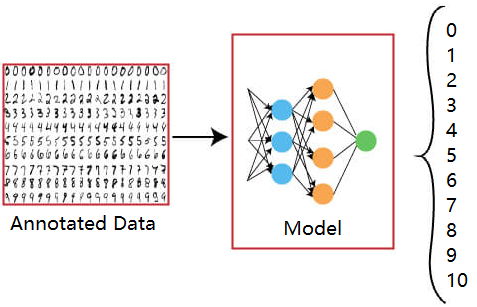

##Pré-Processamento e Extração de Características
  

In [ ]:
class HOG:
  def describe(self,im,pixels_per_cell=(8, 8),cells_per_block=(2, 2)):
    if len(im.shape) > 2 and im.shape[2] == 3:
      im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

    im = cv2.resize(im,(64,128))

    fd, hog_image = feature.hog(im, orientations=9, pixels_per_cell=pixels_per_cell,
                	cells_per_block=cells_per_block,visualize=True)
    return fd,hog_image

In [ ]:
desc = HOG()
for img in x_train[:5]:
  key_pts, hog_img = desc.describe(x_train[0])  
  plot_sidebyside([img,hog_img],
                ['Input','HOG'],
                colormap='gray',
                figsize=(6,4))


In [ ]:
desc = HOG()

N_SAMPLES_TRAIN = 3000
N_SAMPLES_TEST = 500

features = {'train': [], 'test': []}
for img, lbl in zip(x_train[:N_SAMPLES_TRAIN],y_train[:N_SAMPLES_TRAIN]):
  
  feat, _ = desc.describe(img)       
  features['train'].append(feat)
    
#Add to a dictionary
features['train'] = np.reshape(features['train'],(N_SAMPLES_TRAIN,-1))
print('Train Data: ',features['train'].shape)
  


for img, lbl in zip(x_test[:N_SAMPLES_TEST],y_test[:N_SAMPLES_TEST]):
  feat, _ = desc.describe(img)       
  features['test'].append(feat)

#Add to a dictionary
features['test'] = np.reshape(features['test'],(N_SAMPLES_TEST,-1))
print('Test Data: ',features['test'].shape)




#Normalização do Dados

A normalização dos dados é importante para minimizar as distorções nas faixas de valores.

In [ ]:
data = features['train']
print(data[0])

print(np.unique(data[0]))

print("STD Scaler")
data_norm = preprocessing.StandardScaler().fit_transform(data)
print(np.unique(data_norm[0]))

print("MinMax Scaler")
data_norm = preprocessing.MinMaxScaler().fit_transform(data)
print(np.unique(data_norm[0]))



In [ ]:
data_norm_train = preprocessing.MinMaxScaler().fit_transform(features['train'])
data_norm_test = preprocessing.MinMaxScaler().fit_transform(features['test'])

#Classification

Vamos avaliar classificadores conhecidos no estado da arte

* KNN
* Logistic Regression
* Naive Bayes
* Decision Tree
* Support Vector Machine
* Multi-Layer Perceptron



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

K=3
max_iter = 100

models = {}
models['KNN'] = KNeighborsClassifier(n_neighbors=3)
models['NB'] = MultinomialNB()
models['LR'] = LogisticRegression(max_iter=max_iter)
models['DT'] = DecisionTreeClassifier(max_depth=5)
models['SVC'] = SVC(max_iter=max_iter)
models['MLP'] = MLPClassifier(max_iter=max_iter)

In [ ]:
def performance_evaluation(y_test, predictions,info_message,figsize=(18, 4)):
  
  print(f"Evaluation of ", info_message)
  print(f"{metrics.classification_report(y_test, predicted)}\n")
  print(lbls_name)
  disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
  disp.figure_.suptitle("Confusion Matrix")
  plt.show()
  print('\n')
  id = np.random.randint(300)
  idx1,idx2=id,id+10  
  diff = np.absolute(y_test.astype(np.int32) - predictions)  
  idxs = np.where(diff == 0)

  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=figsize)  
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):
      ax.set_axis_off()      
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f'Label: {lbl}')
      ax.text(0.5, 0.0, f'Pred: {prediction}', ha='center', va='center', transform=ax.transAxes)
  
  idxs = np.where(diff != 0)
  plt.show()
  
  print('\n')   
  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=figsize)
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):         
      ax.set_axis_off()      
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f'Label: {lbl}')
      ax.text(0.5, 0.0, f'Pred: {prediction}', ha='center', va='center', transform=ax.transAxes)
  plt.show()
  print('\n')

##Trainamento e Avaliação

In [ ]:
for name in models:
  print('#########################')
  print(f'Training {name}')

  train = data_norm_train
  test = data_norm_test

  model = models[name]
  model.fit(train, y_train[:N_SAMPLES_TRAIN])
  predicted = model.predict(test)
  
  performance_evaluation(y_test[:N_SAMPLES_TEST],predicted,name,figsize=(10,4))
  
  